<a href="https://colab.research.google.com/github/Ido787/ReadMyLips/blob/develop/Copy_of_Lip_Reading_28_5_Habani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Dependencies

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
import tempfile
import shutil
from matplotlib import pyplot as plt
from keras.models import Sequential 
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from google.colab.patches import cv2_imshow

# Configurations

In [ ]:
selected_speakers = [1]
data_dir = '/content/data'

# Build Data Loading Functions

Download the speakers from the dataset

In [ ]:
invalid_speakers = [21]
base_dataset_URL = 'https://spandh.dcs.shef.ac.uk/gridcorpus'
alignment_dir = f'{data_dir}/alignments'
videos_dir = f'{data_dir}/videos'

# Define the URLs for getting the data
get_videos_url = lambda speaker_index : f'{base_dataset_URL}/s{speaker_index}/video/s{speaker_index}.mpg_vcd.zip'
get_alignments_url = lambda speaker_index : f'{base_dataset_URL}/s{speaker_index}/align/s{speaker_index}.tar'


# Filter all the selected speakers
speakers = [speaker for speaker in selected_speakers if speaker not in invalid_speakers]

# If the alignments or the videos folder were not created
if not (os.path.isdir(alignment_dir) or os.path.isdir(videos_dir)):
  with tempfile.TemporaryDirectory() as tmpdir:
    for speaker_index in speakers:
      print(f'Downloading speaker {speaker_index}:')
      
      alignments_path = f'alignments/s{speaker_index}'
      tf.keras.utils.get_file(None, get_alignments_url(speaker_index), extract=True,
                                      cache_dir=tmpdir, cache_subdir = alignments_path)    
      shutil.move(f'{tmpdir}/{alignments_path}/align', f'{alignment_dir}/s{speaker_index}')

      tf.keras.utils.get_file(None, get_videos_url(speaker_index), extract=True,
                                      cache_dir=tmpdir, cache_subdir = 'videos')    
      shutil.move(f'{tmpdir}/videos/s{speaker_index}', f'{videos_dir}/s{speaker_index}')

422746353/422746353 [==============================] - 4s 0us/step


defining the mouth detection model

In [ ]:
!gdown 1OjyocXqGSoNB0HS_PhAE4j2G5YVpwBky
mouth_cascade = cv2.CascadeClassifier('./haarcascade_mcs_mouth.xml')

if mouth_cascade.empty():
  raise IOError('Unable to load the mouth cascade classifier xml file')

Downloading...
From: https://drive.google.com/uc?id=1OjyocXqGSoNB0HS_PhAE4j2G5YVpwBky
To: /content/haarcascade_mcs_mouth.xml
100% 742k/742k [00:00<00:00, 81.8MB/s]


A function to cut the mouth area of a frame using detection model

In [ ]:
def crop_mouth_in_frame(frame):
  # This is used if we want to shrink the frame, currently keeping the original size
  ds_factor = 1
  frame = cv2.resize(frame, None, fx=ds_factor, fy=ds_factor, interpolation=cv2.INTER_AREA)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  mouth_rects = mouth_cascade.detectMultiScale(gray, 1.7, 11)

  for (x,y,w,h) in mouth_rects:
      y = int(y - 0.5*h)
      break

  frame_cut = frame[y:y+h,x:x+w]
  frame_resize = cv2.resize(frame_cut, (75,50))

  return frame_resize

Crop and preprocess the video

In [ ]:
height_crop = slice(190, 236)
width_crop = slice(80, 220)

# I replaced this function with mine
def crop_frame(frames):
  return frames[height_crop, width_crop, :]

# you didnt use this function
def preprocess_frame(frame):
  new_frame = tf.image.rgb_to_grayscale(frame)

In [ ]:
def load_video(path: str) -> List[float]: 
      cap = cv2.VideoCapture(path)
      frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

      # Preprocessing
      frames = []

      for _ in range(frames_count): 
          ret, frame = cap.read()
          frame = crop_mouth_in_frame(frame)
          # frame = crop_frame(frame)
          frame = tf.image.rgb_to_grayscale(frame)

          frames.append(frame)

      cap.release()
      
      # Normalize the frames (mean centering)
      mean = tf.math.reduce_mean(frames)
      std = tf.math.reduce_std(tf.cast(frames, tf.float32))

      return tf.cast((frames - mean), tf.float32) / std

Create the vocabulary for the alignments

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
oov_token=""

# This adds an extra character to the vocab - oov (out of vocabulary) token
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token=oov_token)

num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token=oov_token, invert=True
)

vocab_size = char_to_num.vocabulary_size()

In [ ]:
sample_word = "habani"
encoded = char_to_num([*sample_word])

encoded.numpy()

array([ 8,  1,  2,  1, 14,  9])

In [ ]:
decoded = num_to_char(encoded)

print("".join([bytes.decode(char) for char in decoded.numpy()]))

habani


In [ ]:
special_token = 'sil'

def load_alignments(path: str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    
    tokens = []

    # Extract an array of words seperated by space from the alignment file
    for line in lines:
        start, end, token = line.split()
        
        if token != special_token: 
            tokens = [*tokens, ' ', token]

    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(video_path: str):
    # Convert from tensor to string
    video_path = bytes.decode(video_path.numpy())

    alignment_path = video_path.replace("videos", "alignments").replace("mpg","align")
    
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

Test the data loading

In [ ]:
test_path = './data/videos/s1/bbaf2n.mpg'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

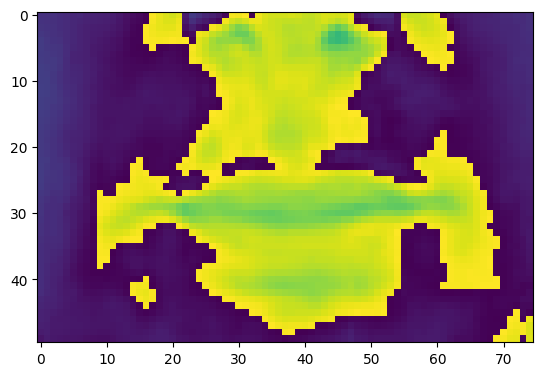

In [ ]:
plt.imshow(frames[71])
alignments

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [ ]:
# This is necessary since we might get a prefetch dataset
# or something but we want to access the data eagerly
def mappable_function(path: str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [ ]:
batch_size = 10
train_percentage = 0.1

data = tf.data.Dataset.list_files(f'{videos_dir}/*/*.mpg')

data_count = len(data)
preprocessed_data = data.shuffle(data_count, reshuffle_each_iteration=False).map(mappable_function).prefetch(tf.data.AUTOTUNE)

train_count = int(train_percentage * data_count)

train = preprocessed_data.take(train_count).padded_batch(batch_size, padded_shapes=([75,None,None,None],[vocab_size]))
test = preprocessed_data.skip(train_count).padded_batch(batch_size, padded_shapes=([75,None,None,None],[vocab_size]))

In [ ]:
print('train', len(train), 'test', len(test))

train 10 test 90


Test data extraction and loading

In [ ]:
batch = train.as_numpy_iterator().next()

In [ ]:
batched_videos, batched_alignments = batch

In [ ]:
sample_video = batched_videos[0]
sample_alignments = batched_alignments[0]

In [ ]:
imageio.mimsave('./animation.gif', sample_video, fps=10)

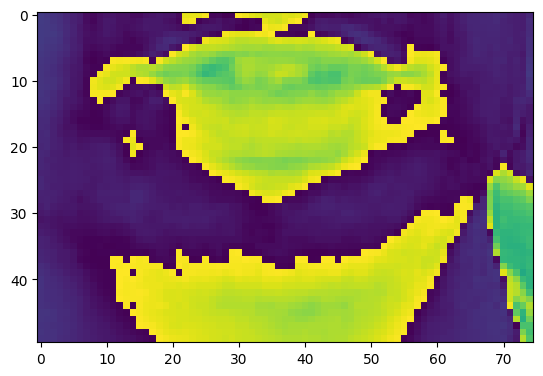

In [ ]:
plt.imshow(sample_video[35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in sample_alignments])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white in l zero please'>

# 3. Design the Deep Neural Network

In [ ]:
input_shape = sample_video.shape
input_shape

(75, 50, 75, 1)

In [ ]:
model = Sequential()
# Three layers of 3D/spatiotemporal convolutions.
model.add(Conv3D(128, 3, input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# Flattens each time slice independently.
model.add(TimeDistributed(Flatten()))

# Two layers of Bi-LSTM's.
# return_sequences=True makes the the network output a sequence of predictions, one for each time step of the input sequence.
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

# Linear transformation (dense layer) and output (softmax layer).
model.add(Dense(vocab_size + 1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.output_shape

(None, 75, 41)

In [ ]:
yhat = model.predict(np.expand_dims(sample_video, axis=0))[0]

1/1 [==============================] - 5s 5s/step


In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat])

<tf.Tensor: shape=(), dtype=string, numpy=b'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!j'>

# 4. Setup Training Options and Train

In [ ]:
learning_rate_decay_start_epoch = 100
learning_rate = 0.0003

In [ ]:
def scheduler(epoch, lr):
    if epoch < learning_rate_decay_start_epoch:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
train

<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [ ]:
model.fit(train, epochs=100, callbacks=[checkpoint_callback, schedule_callback])

In [ ]:
!zip -r /content/checkpoint.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/checkpoint (deflated 48%)
  adding: content/models/checkpoint.data-00000-of-00001 (deflated 12%)
  adding: content/models/checkpoint.index (deflated 72%)


In [ ]:
from google.colab import files
files.download("/content/checkpoint.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!du -h /content/checkpoint.zip

86M	/content/checkpoint.zip


# 5. Make a Prediction 

In [ ]:
def calculate_accuracy(y_true, y_pred):
    # Convert y_pred to label sequences by using argmax
    pred_labels, _ = tf.keras.backend.ctc_decode(y_pred, tf.shape(y_pred)[1])

    # Convert sparse tensor y_true to dense tensor for comparison
    y_true = tf.sparse.to_dense(y_true)

    # Compare the predicted labels with true labels
    matches = tf.equal(pred_labels, y_true)

    # Calculate accuracy by taking the mean of matches
    accuracy = tf.reduce_mean(tf.cast(matches, tf.float32))
    
    return accuracy

In [ ]:
# loss = model.evaluate(test)

In [ ]:
sample = test.as_numpy_iterator().next()

In [ ]:
batched_videos, batched_alignments = sample

In [ ]:
frames = batched_videos[0]
alignments = batched_alignments[0]

In [ ]:
yhat = model.predict(np.expand_dims(frames, axis=0))

1/1 [==============================] - 0s 32ms/step


In [ ]:
yhat_tensor = tf.convert_to_tensor(yhat)

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

FailedPreconditionError: ignored

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in alignments]

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]